In [1]:
import argparse
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
import functools

In [2]:
image = cv2.imread('plate3.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

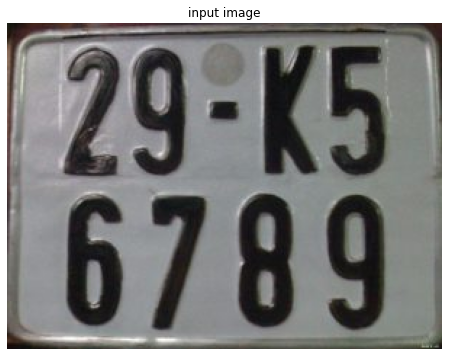

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


display(image, 'input image')

In [4]:
# Apply Gaussian blurring and thresholding 
# to reveal the characters on the license plate
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)

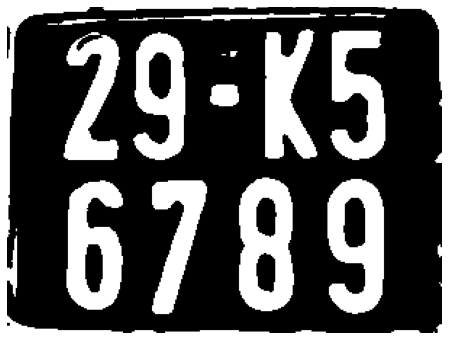

In [5]:
display(thresh, '')

In [6]:
# Perform connected components analysis on the thresholded images and
# initialize the mask to hold only the components we are interested in
_, labels = cv2.connectedComponents(thresh)
mask = np.zeros(thresh.shape, dtype="uint8")

In [7]:
# Set lower bound and upper bound criteria for characters
total_pixels = image.shape[0] * image.shape[1]
lower = total_pixels // 70 # heuristic param, can be fine tuned if necessary
upper = total_pixels // 20 # heuristic param, can be fine tuned if necessary

In [8]:
# Loop over the unique components
for (i, label) in enumerate(np.unique(labels)):
	# If this is the background label, ignore it
	if label == 0:
		continue
 
	# Otherwise, construct the label mask to display only connected component
	# for the current label
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
 
	# If the number of pixels in the component is between lower bound and upper bound, 
	# add it to our mask
	if numPixels > lower and numPixels < upper:
		mask = cv2.add(mask, labelMask)

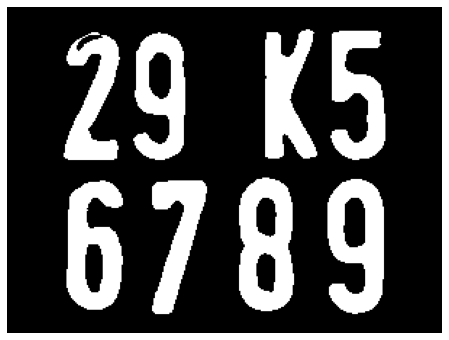

In [9]:
display(mask, '')

In [10]:
# Find contours and get bounding box for each contour
cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

In [11]:
# Sort the bounding boxes from left to right, top to bottom
# sort by Y first, and then sort by X if Ys are similar
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )

In [12]:
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
chars = [
    '0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G',
    'H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
    ]

In [13]:
model = load_model('characters_model.weights', compile=False)

1/1 [==============================] - 0s 69ms/step


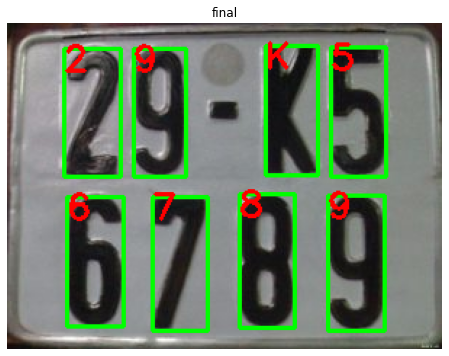

Vehicle plate: 29K56789


In [14]:
vehicle_plate = ""
# Loop over the bounding boxes
for rect in boundingBoxes:

    # Get the coordinates from the bounding box
    x,y,w,h = rect

    # Crop the character from the mask
    # and apply bitwise_not because in our training data for pre-trained model
    # the characters are black on a white background
    crop = mask[y:y+h, x:x+w]
    crop = cv2.bitwise_not(crop)

    # Get the number of rows and columns for each cropped image
    # and calculate the padding to match the image input of pre-trained model
    rows = crop.shape[0]
    columns = crop.shape[1]
    paddingY = (TARGET_HEIGHT - rows) // 2 if rows < TARGET_HEIGHT else int(0.17 * rows)
    paddingX = (TARGET_WIDTH - columns) // 2 if columns < TARGET_WIDTH else int(0.45 * columns)
    
    # Apply padding to make the image fit for neural network model
    crop = cv2.copyMakeBorder(crop, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, None, 255)

    # Convert and resize image
    crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)     
    crop = cv2.resize(crop, (TARGET_WIDTH, TARGET_HEIGHT))

    # Prepare data for prediction
    crop = crop.astype("float") / 255.0
    crop = img_to_array(crop)
    crop = np.expand_dims(crop, axis=0)

    # Make prediction
    prob = model.predict(crop)[0]
    idx = np.argsort(prob)[-1]
    vehicle_plate += chars[idx]

    # Show bounding box and prediction on image
    cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 2)
    cv2.putText(image, chars[idx], (x,y+15), 0, 0.8, (0, 0, 255), 2)

# Show final image
display(image, 'final')
print("Vehicle plate: " + vehicle_plate)
